<a href="https://colab.research.google.com/github/JanyamonKwancheun/HandsOn_W08_6610742170/blob/main/SF251_HW6_CN240_Linear_Regression_(TH).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 6 - Linear Regression

## Due: Sunday 20th, April 2025. 23:59

## Point: 5

**Note**: ถ้ามีปัญหาอ่านโจทย์ไม่เข้าใจ ถามได้นะครับ


## Description:

การบ้านนี้จะแนะนำขั้นตอนพื้นฐานของการทำ machine learning โดยใช้ linear regression มีสองชุดข้อมูลที่เราจะใช้

1. ชุดข้อมูล Diabetes จาก `sklearn`
2. ชุดข้อมูล housing จาก kaggle

# 1. The Diabates dataset (2 points)

ในโจทย์ปัญหานี้ เราจะสำรวจชุดข้อมูล diabetes และพยายามทำนายการดำเนินของโรค

**ขั้นตอน**:
1. Import libraries ที่จำเป็น
2. โหลดและแบ่งข้อมูล train/test
3. สำรวจข้อมูล
4. การเลือก Feature และ Feature Engineering
5. การเลือกโมเดลโดยใช้ Cross Validation
6. การฝึกโมเดลที่ดีที่สุดบนชุดข้อมูลเต็ม
7. ตรวจสอบผลลัพธ์

<br>

---

## 1.1 Import necessary libraries

ลองดูสิ่งที่เรานำเข้าทั้งหมด บางอย่างคุณอาจจะยังไม่รู้จัก และการบ้านจะอธิบายให้คุณทราบในภายหลังว่าสิ่งเหล่านั้นถูกใช้อย่างไร

In [55]:
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1.2 Load and split the Diabates dataset

- โหลดชุดข้อมูลเบาหวานโดยใช้ฟังก์ชัน `load_diabetes()` ของ sklearn
  - คุณสามารถอ่านเพิ่มเติมเกี่ยวกับชุดข้อมูลและตัวแปรได้ที่นี่ (https://scikit-learn.org/1.5/datasets/toy_dataset.html#diabetes-dataset).

In [56]:
# Load the Diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X = pd.DataFrame(X, columns=diabetes.feature_names) # The dataset is is numpy array format

## 1.2.1 Split Training/Testing (0.25 points)

- หากคุณไม่ได้รับ testing set คุณควร **แบ่ง training และ testing ตั้งแต่ตอนเริ่มต้น**
- เหตุผลสำคัญคือ testing set ควรจะบริสุทธิ์และคุณไม่ควรดูมันจนกว่าจะถึงตอนสุดท้าย

คำอธิบายงาน:
- ใช้ `train_test_split` เพื่อแบ่งชุดข้อมูลแต่ละ feature ออกเป็นชุด training และ testing ([เอกสารอ้างอิง](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html))
   - กำหนด `test_size=0.2` เพื่อใช้ข้อมูล 80% สำหรับการ training และ 20% สำหรับการ testing
   - กำหนด `random_state=777` เพื่อให้ผลลัพธ์สามารถทำซ้ำได้
- สุดท้าย print shapes ของชุดข้อมูล training และ testing ที่ได้

In [58]:
X_train, X_test, y_train, y_test =  train_test_split(X,
                                                     y,
                                                     test_size=0.2,
                                                     random_state=777)

print(X_train.shape)
print(X_test.shape)

(353, 10)
(89, 10)


# 1.2 Data Exploration

## 1.2.0 Exploring the data

- สร้าง pandas DataFrame จากชุดข้อมูลเพื่อให้จัดการได้ง่ายขึ้น
- แสดงข้อมูลพื้นฐานเกี่ยวกับชุดข้อมูลโดยใช้ `df.info()` และ `df.describe()`

In [65]:
# Create a DataFrame for easier exploration
df = pd.DataFrame(X_train, columns=diabetes.feature_names)
df['target'] = y_train

df.head()

# Display basic information about the dataset
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 353 entries, 7 to 103
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     353 non-null    float64
 1   sex     353 non-null    float64
 2   bmi     353 non-null    float64
 3   bp      353 non-null    float64
 4   s1      353 non-null    float64
 5   s2      353 non-null    float64
 6   s3      353 non-null    float64
 7   s4      353 non-null    float64
 8   s5      353 non-null    float64
 9   s6      353 non-null    float64
 10  target  353 non-null    float64
dtypes: float64(11)
memory usage: 33.1 KB
None

Descriptive statistics:
              age         sex         bmi          bp          s1          s2  \
count  353.000000  353.000000  353.000000  353.000000  353.000000  353.000000   
mean     0.001380   -0.000356    0.000252    0.000575   -0.000680   -0.000739   
std      0.047389    0.047609    0.046936    0.048247    0.047960    0.048332   
min     -0.107226   -0.

## 1.2.1 Visualizing all the features (0.5 point)

- สร้าง histogram สำหรับทุก feature เพื่อแสดงการกระจายตัวของข้อมูลโดยใช้ plotnine
  - ขั้นแรก สร้าง `DataFrame` ใหม่สำหรับการพล็อตโดยใช้ `melt` กับ dataframe `df` โดยใช้ทุกคอลัมน์ (`id_vars=None` หรือไม่จำเป็นต้องระบุ `id_vars` เนื่องจากค่าเริ่มต้นคือ `None` และไม่จำเป็นต้องระบุค่า `value_vars` เพราะใช้ทุก columns หรือจะใส่ทุก ชื่อทก columns ก็ได้)
    - ตั้งค่า `var_name` เป็น `'feature'` และ `value_name` เป็น `'value'`
  - ขั้นที่สอง พล็อต histogram สำหรับทุก `feature` ด้วย `facet_wrap`  
    - ตั้งค่า `scales` ของ `facet_wrap` เป็น `free` เพื่อให้แต่ละ feature โชว์ค่าแกรน `x` กับ `y` แยกไปแต่ละตัว
    - ตั้งค่า histogram `bins` เป็น `30` อย่าเปลี่ยนการตั้งค่าอื่น ๆ

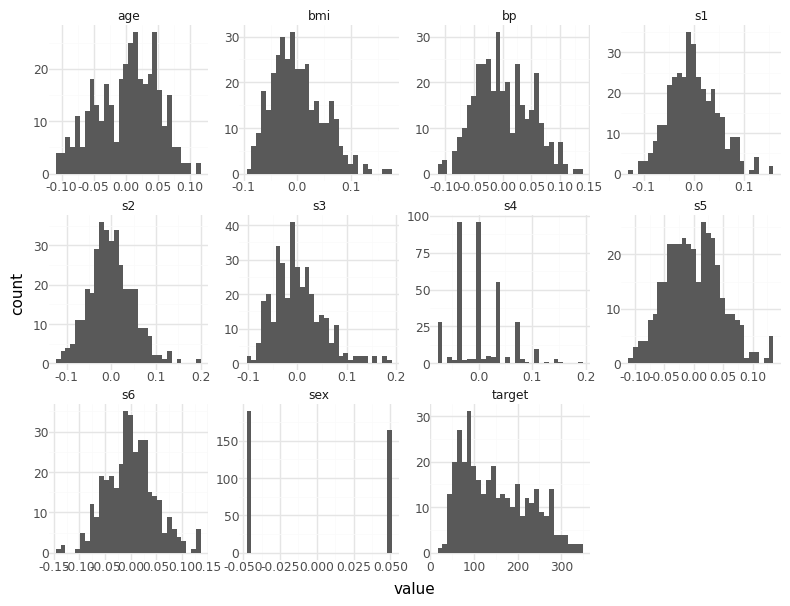

In [ ]:
# Example with theme_minimal()

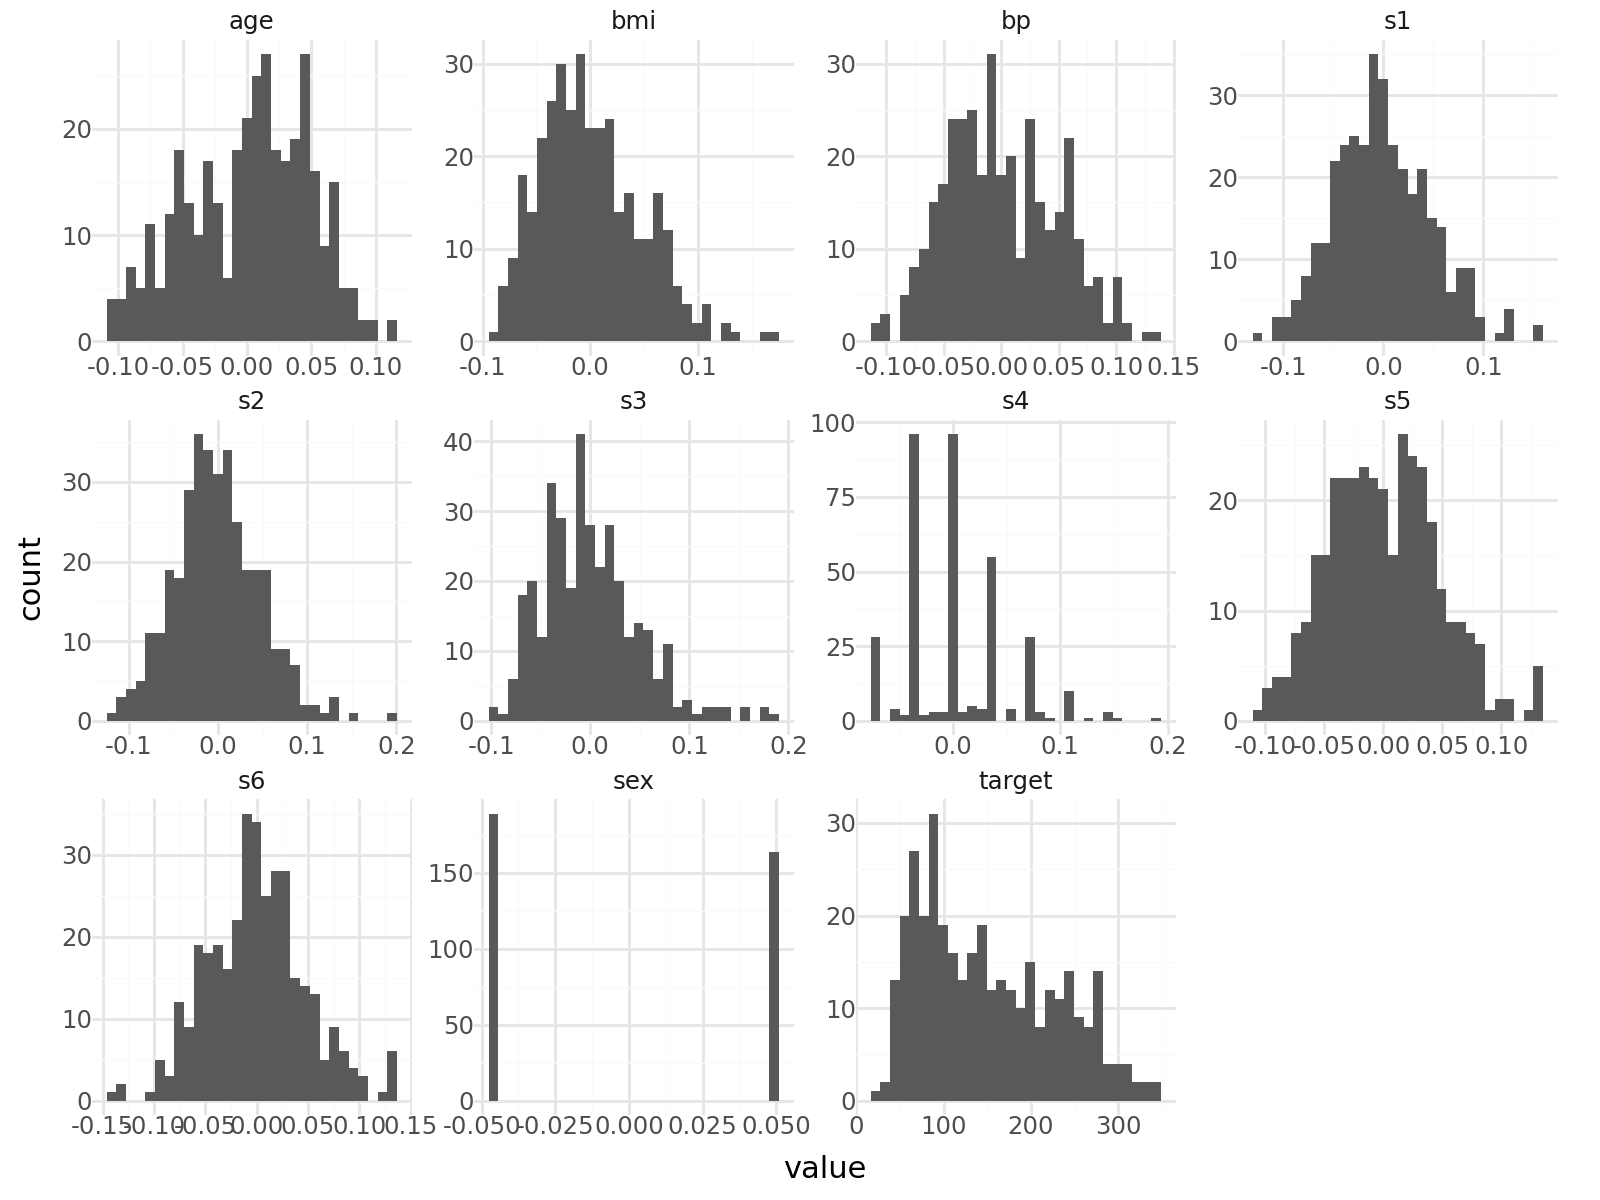

In [70]:
toplot_df = df.melt(var_name='feature', value_name='value')
(
    ggplot(toplot_df, aes(x= 'value')) +
    geom_histogram(bins=30) +
    facet_wrap('~feature' , scales ='free') +
    theme_minimal() +
    theme(figure_size=(8,6))
)

## 1.2.3 What do you notice? (0.125 points)
- เห็นอะไรบ้างจาก graph ด้านบน. subgraphs แต่ละอันคือ features ให้เขียนด้านล่างว่ามีอะไรบ้าง

**Answer**: กราฟส่วนใหญ่เป็น normal distribution และส่วนน้อย เช่น sex จะเป็น categorical

## 1.2.4 Pandas Scatter Plot Matrix: (0.125 points)

- ในทางปฏิบัติ คุณควรตรวจสอบแผนภาพการกระจาย (scatter plots) ของคู่ตัวแปรทั้งหมดเพื่อตรวจสอบคู่ features ที่มีความสัมพันธ์กัน
- โดยทั่วไป คุณไม่ควรรวม features ที่มีความสัมพันธ์กันสูง คุณควรรวมเพียงหนึ่งในนั้น เพราะว่า โมเดลจะไม่รู้ว่าจะใช้ตัวไหนหรือแบ่งงานอย่างไร ถ้ามี features คล้ายกันมากๆ ปัญหานี้เรียกว่า **colinearity** ที่เคยพูดไปในคาบ
- วิธีหนึ่งในการตรวจสอบคือการใช้ `pandas.plotting.scatter_matrix` ([Documentation](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html))
- รันโค้ดด้านล่าง คุณเห็น features ใดที่มี **highly correlated** (แสดงความสัมพันธ์เชิงเส้นใดๆ) หรือไม่? ใส่คำตอบในช่องด้านล่าง


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='sex', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='bp', ylabel='age'>,
        <Axes: xlabel='s1', ylabel='age'>,
        <Axes: xlabel='s2', ylabel='age'>,
        <Axes: xlabel='s3', ylabel='age'>,
        <Axes: xlabel='s4', ylabel='age'>,
        <Axes: xlabel='s5', ylabel='age'>,
        <Axes: xlabel='s6', ylabel='age'>,
        <Axes: xlabel='target', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='sex'>,
        <Axes: xlabel='sex', ylabel='sex'>,
        <Axes: xlabel='bmi', ylabel='sex'>,
        <Axes: xlabel='bp', ylabel='sex'>,
        <Axes: xlabel='s1', ylabel='sex'>,
        <Axes: xlabel='s2', ylabel='sex'>,
        <Axes: xlabel='s3', ylabel='sex'>,
        <Axes: xlabel='s4', ylabel='sex'>,
        <Axes: xlabel='s5', ylabel='sex'>,
        <Axes: xlabel='s6', ylabel='sex'>,
        <Axes: xlabel='target', ylabel='sex'>],
       [<Axes: xlabel='age', ylabel='b

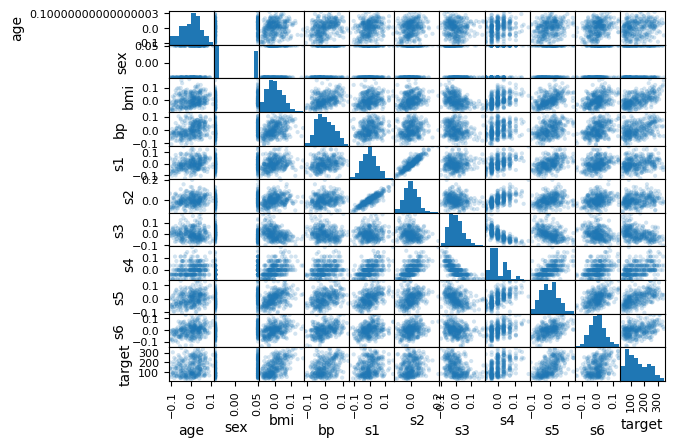

In [71]:
pd.plotting.scatter_matrix(df, alpha=0.2)

**Answer**:

## 1.3 Feature Selection and Engineering (0.25 points)

- หัวใจสำคัญของ ML คือการเลือก features เพื่อมาใช้เรียนรู้
- โดยทั่วไป คุณต้องมีความรู้ในโดเมนเพื่อทำการเลือก feature และ feature engineering ด้วยตนเองอย่างมีประสิทธิภาพ
- เนื่องจากเราไม่ใช่ผู้เชี่ยวชาญในเรื่องโรคเบาหวาน เราจะเลือกเพียงไม่กี่ feature ที่ไม่มีความสัมพันธ์กันสูงและทำการแปลงแบบ polynomial และ log บน feature ตัวเลขบางตัว

คำอธิบายงาน:
- สร้างชุดข้อมูลใหม่ 3 ชุดที่มีเฉพาะ feature ต่อไปนี้
  1. `X_train_small`: `age`, `sex`, `bmi`, `bp`, `s1`, `s4`, `s6`
  2. `X_train_small_poly`: `age`, `sex`, `bmi`, `bp`, `s1`, `s4`, `s6`, `s1^2`, `s4^2`, `s6^2`
    - `s1^2` หมายถึง `s1**2`
  3. `X_train_small_log`: `age`, `sex`, `bmi`, `bp`, `s1`, `s4`, `s6`, `log_s1`, `log_s4`, `log_s6`
    - เราจะใช้ลอการิทึมธรรมชาติ เฉพาะ `np.log1p()` ฟังก์ชันนี้เพิ่มค่าหนึ่งก่อนทำการคำนวณลอการิทึม (ทำไมเราจึงต้องเพิ่มหนึ่งก่อนคำนวณลอการิทึมในที่นี้?)
- **หมายเหตุ**: เพื่อให้โจทย์นี้ง่าย เราจะไม่ทำการ standardize feature ทั้งหมดในที่นี้ แต่ในทางปฏิบัติ (และในคำถามถัดไป) คุณควรทำ

In [63]:
X_train_small = X_train[["age", "sex","bmi", "bp", "s1", "s4", "s6"]]

X_train_small_poly = X_train_small.copy()
X_train_small_poly["s1^2"] = X_train_small_poly["s1"]**2
X_train_small_poly["s4^2"] = X_train_small_poly["s4"]**2
X_train_small_poly["s6^2"] = X_train_small_poly["s6"]**2
# Create s1^2, s4^2, s6^2 features



X_train_small_log = X_train_small.copy()
X_train_small_log["log_s1"] = np.log1p(X_train_small_log["s1"])
X_train_small_log["log_s4"] = np.log1p(X_train_small_log["s4"])
X_train_small_log["log_s6"] = np.log1p(X_train_small_log["s6"])
# Create log_s1, log_s4, log_s6 features




X_trains = {
  "small" : X_train_small,
  "small_poly" : X_train_small_poly,
  "small_log" : X_train_small_log
}

## 1.4 Cross-Validation for Model Selection (0.25 points)

- สำหรับขั้นตอนนี้ เราจะใช้ Cross-Validation เพื่อเลือกการรวมกันที่ดีที่สุดระหว่างโมเดลที่ดีที่สุดและfeature set
- เราจะพิจารณา 3 โมเดล:
  - linear regression (`LinearRegression()`)
  - lasso (`Lasso(alpha=1.0)`)
  - ridge regression (`Ridge(alpha=1.0)`)
- เราจะทำการทดสอบแบบ 5-fold cross-validation โดยใช้ `cross_val_score` กับการวัดความผิดพลาดแบบ negative mean squared error `scoring='neg_mean_squared_error'`
 - 'neg_mean_squared_error' คือแค่ -1 * mean squared error เท่านั้น `sklearn` มีเมตริกนี้เนื่องจากใช้หลักการว่าค่าที่สูงกว่าคือค่าที่ดีกว่า
 - [เอกสารอ้างอิง](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
- **Note**: พยายามทำความเข้าใจ code อันนี้


In [72]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0)
}

cv_results = []

for model_name, model in models.items():
  for X_name, X_temp in X_trains.items():
    cv_scores = cross_val_score(estimator = model,
                                X = X_temp ,
                                y = y_train ,
                                cv = 5 ,   #Fill in your answer here
                                scoring='neg_mean_squared_error')
    mean_cv_mse = -cv_scores.mean()  # We multiply by -1* because we want MSE and not negative MSE.
    cv_results.append({
         'Feature Set': X_name,
         'Model': model_name,
         'Mean CV MSE': mean_cv_mse,
    })

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)

  Feature Set              Model  Mean CV MSE
0       small  Linear Regression  3515.097644
1  small_poly  Linear Regression  3514.425897
2   small_log  Linear Regression  3507.689449
3       small   Ridge Regression  4080.268956
4  small_poly   Ridge Regression  4080.014080
5   small_log   Ridge Regression  3998.959153
6       small   Lasso Regression  4369.182151
7  small_poly   Lasso Regression  4369.182151
8   small_log   Lasso Regression  4369.182151


## 1.5 Fitting the best model to the full training data (0.25 points)

- สุดท้าย เราจะทำการ fit โมเดลที่ดีที่สุด + feature set บนข้อมูลฝึกฝนเต็มรูปแบบ (`X_train`)
- หลังจาก fitting แล้ว ให้พิมพ์ค่า coefficient `.coef_`

In [75]:
best_model = LinearRegression()
X_train_best = X_trains["small_log"]

# Fit the model again
best_model.fit(X_train_best , y_train)

# print coef ของ model
print(best_model.coef_)

[   38.0417518   -251.12336256   615.92679802   380.61475637
  2086.52874438 -2286.09240501  4868.39833457 -2291.73812469
  2790.42112633 -4740.44448999]


## 1.6 Explore the results (0.25 points)

- คำนวณค่า Mean Squared Error สำหรับข้อมูลฝึกสอน (train) และข้อมูลทดสอบ (test) และแสดงผลลัพธ์ออกมา
- คุณอาจพบว่าฟังก์ชัน `mean_squared_error()` มีประโยชน์ [เอกสารอ้างอิง](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html)
- สำหรับ testing data จะต้อง ทำการสร้าง data ที่มี features เสร็จเดียวกันกับ training data ก่อน!

In [78]:
X_test_small_log = X_test[['age', 'sex', 'bmi', 'bp', 's1', 's4', 's6']].copy()
X_test_small_log['log_s1'] = np.log1p(X_test_small_log['s1'])
X_test_small_log['log_s4'] = np.log1p(X_test_small_log['s4'])
X_test_small_log['log_s6'] = np.log1p(X_test_small_log['s6'])

mse_train = mean_squared_error(y_train, best_model.predict(X_train_best))

mse_test = mean_squared_error(y_test, best_model.predict(X_test_small_log))


print(f"Training MSE {mse_train:.2f}. Testing MSE {mse_test:.2f}")

Training MSE 3271.27. Testing MSE 2630.02


<br>

---

# 2. Housing Dataset (3 points)

สำหรับคำถามนี้ เราจะใช้ข้อมูลที่อยู่อาศัยจาก [Kaggle](https://www.kaggle.com/competitions/home-data-for-ml-course/data) competition เราจะใช้เฉพาะ training data เราจะทำตามขั้นตอนการทำงานเหมือนกับข้อที่แล้ว การบ้านจะแนะนำคุณผ่านทุกขั้นตอน การบ้านนี้จะใช้เวลาไปกับการ clean data เยอะ

- คุณสามารถหาข้อมูลการฝึกได้ [ที่นี่](https://github.com/yongsa-nut/TU_CN240_DataScience_671/blob/main/Data/train.csv)
- การบ้าน adapt มาจาก [ที่นี่](https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning/notebook)

**เป้าหมาย:**
- เป้าหมายของเราคือการทำนาย `SalePrice`

**Hint**:
- ถ้ามี error แนะนำให้รันข้อมูลใหม่จากด้านบน

## 2.0 Load the data

In [79]:
!wget -O house_train.csv https://github.com/yongsa-nut/TU_CN240_DataScience_671/raw/refs/heads/main/Data/train.csv

--2025-04-20 16:30:00--  https://github.com/yongsa-nut/TU_CN240_DataScience_671/raw/refs/heads/main/Data/train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yongsa-nut/TU_CN240_DataScience_671/refs/heads/main/Data/train.csv [following]
--2025-04-20 16:30:00--  https://raw.githubusercontent.com/yongsa-nut/TU_CN240_DataScience_671/refs/heads/main/Data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_train.csv’

house_train.csv     100%[===================>] 449.88K  --.-KB/s    in 0.007s  

2025-04-20 16:30:00 (60.6 MB/s) - ‘house_train.c

In [80]:
# Loading the data
house_df = pd.read_csv("house_train.csv", index_col=0)
house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.1 Explore the data

- จากการดูแบบคร่าวๆ ข้างบน คุณควรจะเห็นว่ามีบาง features ที่มีค่าที่ขาดหายไป `NaN` จำนวนมาก
- นอกจากนี้ ข้อมูลนี้มี features เยอะมาก!
- เราสามารถใช้ `.info()` เพื่อตรวจสอบจำนวนของ `NaN` (Non-Null Count) และประเภทของคุณลักษณะต่างๆ
 - ตัวอย่างเช่น ` 5   Alley          91 non-null     object` แสดงว่ามีแค่ 91 จาก 1460 เท่านั้นที่มีค่าจริงๆ ไม่หาย

In [81]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

## 2.2 Drop features with lots of missing values (0.25 points)

- เราจะทิ้ง features ที่มีค่าที่หายไปจำนวนมาก เนื่องจากมีแนวโน้มว่าสิ่งเหล่านี้**มีข้อมูลไม่เพียงพอสำหรับการทำนาย** (ทำไม?)
- **Task**: เอา features ทั้งหมดที่มีค่าที่ไม่ใช่ null/NaN น้อยกว่า 1000 (ตัวเลขนี้เป็นการกำหนดโดยพลการ) ออกจาก dataframe
  - **Note**: ตัวเลข 1000 เป็นตัวเลขที่ผมเลือกมาเองแบบสุ่มๆ ในชีวิตจริงอาจจะต้องมีการทดสอบเพิ่มเติมว่าเหมาะสมไหม
- ควรจะมี 74 คอลัมน์เหลืออยู่

In [21]:
col_to_drop = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] # here

house_df_nn = house_df.drop(labels=col_to_drop, axis = 1)
house_df_nn.shape

(1460, 74)

### 2.3 Visualize features
- ต่อไปเราต้องการ visualize features ทั้งหมด
- เราจะแบ่ง features ออกเป็นสองกลุ่ม: ตัวเลข (numerical) และ หมวดหมู่ (categorical) เนื่องจากต้องใช้วิธีการพล็อตที่แตกต่างกัน
- ในชีวิตจริง คุณต้องอ่านคำอธิบายของแต่ละตัวแปรและตัดสินใจว่าตัวแปรใดเป็นประเภทใด (คุณสามารถอ่านได้[ที่นี่](https://www.kaggle.com/competitions/home-data-for-ml-course/data) ในส่วน data fields)
- เพื่อประหยัดเวลาของคุณ โค้ดด้านล่างแสดงวิธีหนึ่งในการแยกตัวแปรตามประเภทอย่างรวดเร็ว (`object` (categorical) และ `non object` (numerical))
  - คุณสามารถอ่านเพิ่มเติมเกี่ยวกับ `select_dtypes()` ได้[ที่นี่](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html)
- อย่างไรก็ตาม มีตัวแปรหนึ่งคือ `MSSubClass` ที่เป็นตัวแปรเชิงหมวดหมู่ แต่ pandas จดจำว่าเป็น `int` ดังนั้นเราจะต้องลบตัวแปรนี้ออกจากกลุ่มตัวเลขและเพิ่มเข้าไปในกลุ่มหมวดหมู่ (เราจะรู้ได้ก็ต้องเมื่อเราเข้าใจ feature นี้!)

In [82]:
numeric_ = house_df_nn.select_dtypes(exclude=['object']).copy()
numeric_ = numeric_.drop(['MSSubClass'], axis=1)
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [83]:
cat_ = house_df_nn.select_dtypes(include=['object']).copy()
cat_['MSSubClass'] = house_df_nn['MSSubClass']   #MSSubClass is nominal
cat_.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

### 2.3.1 Plot the numerical variables using histrogram + facet_wrap() (0.25 points)

- แสดงกราฟตัวแปรเชิงตัวเลขทั้งหมดด้านล่างโดยใช้ histogram และ facet_wrap
- ปรับพารามิเตอร์ของ histogram ตามที่คุณเห็นว่าเหมาะสม
- (อีกทางเลือกหนึ่ง เราสามารถใช้ boxplot/violen plot ได้เช่นกัน เราจะทำสิ่งนี้ในภายหลัง)
- **Note**: คุณจะ เห็น warining เพราะบาง row ยังมี `NaN` อยู่

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 348 rows containing non-finite values.


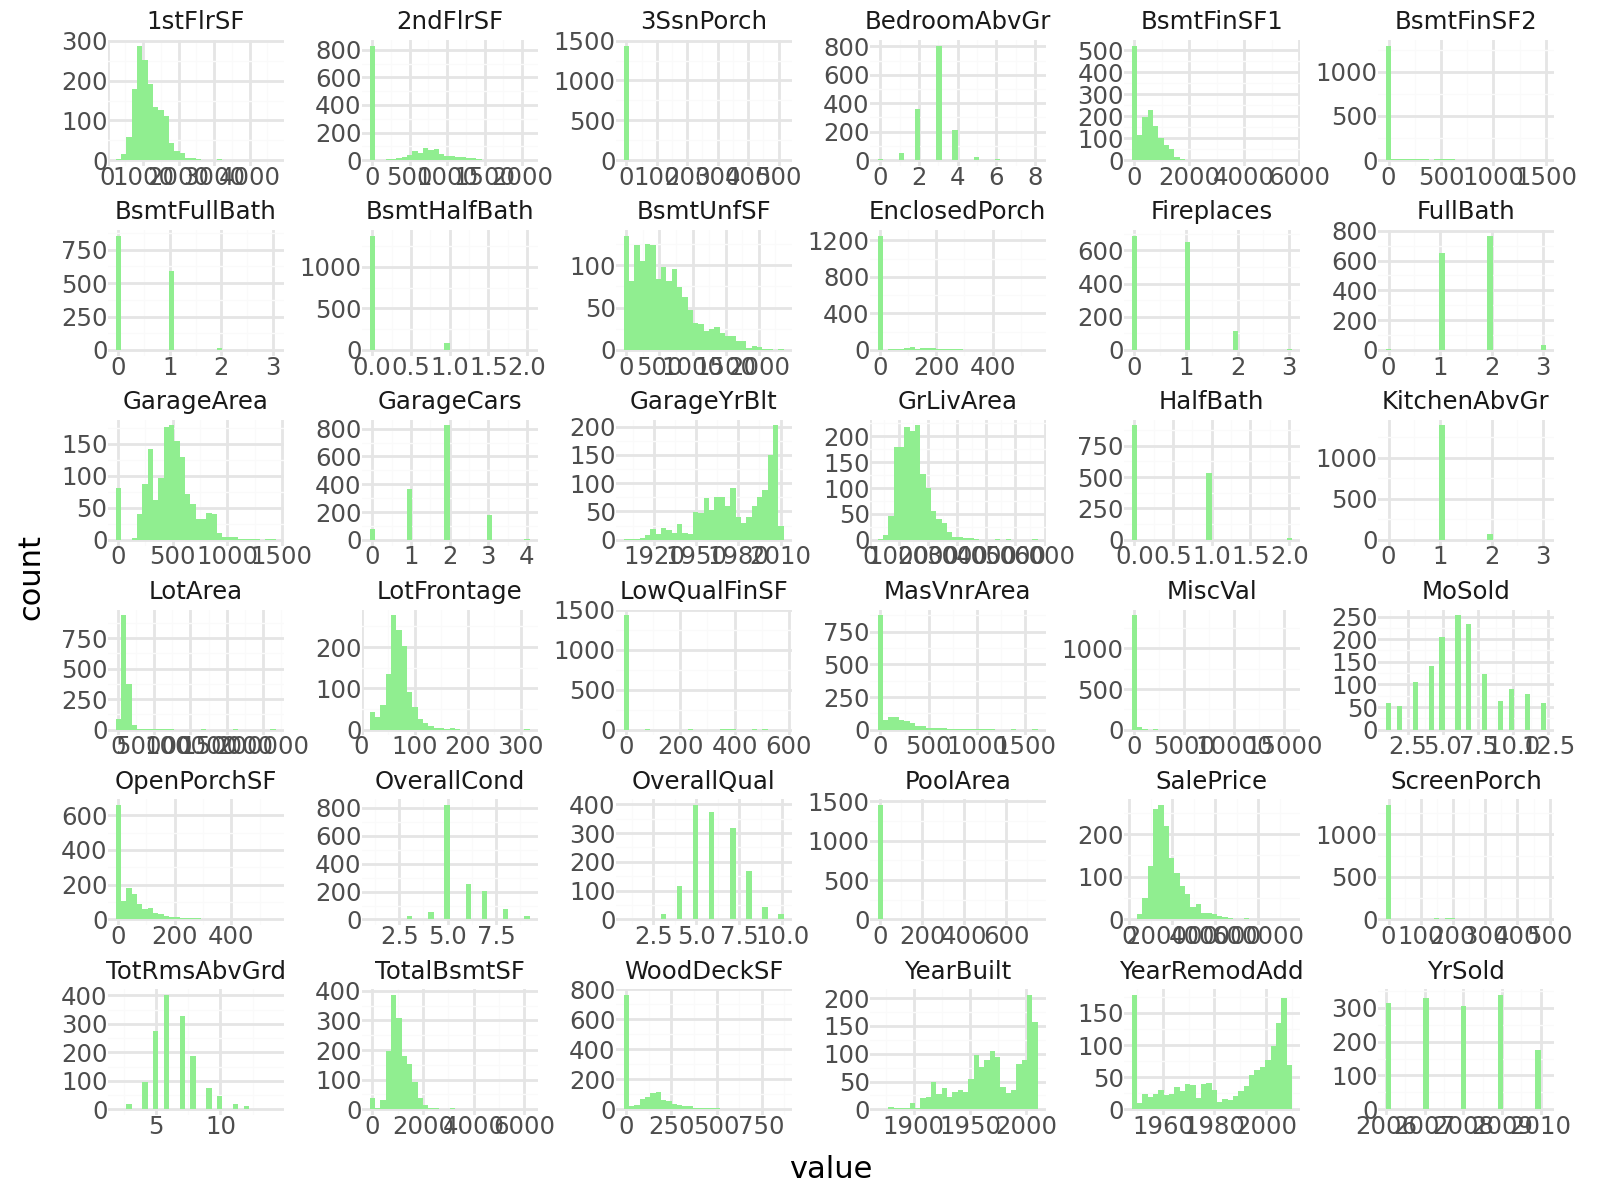

In [84]:
toplot_numeric_df = numeric_.melt(var_name='feature', value_name='value')
(
    ggplot(toplot_numeric_df, aes(x='value')) +
    geom_histogram(bins=30 , fill='lightgreen') +
    facet_wrap('~feature', scales ='free') +
    theme_minimal() +
    theme(figure_size=(8,6))
)

### 2.3.2 Plot the cateogrical variables using barplot + facet_wrap() (0.25 points)
- ใช้ `barplot` and `facet_wrap` เพื่อ plot all categorical variables

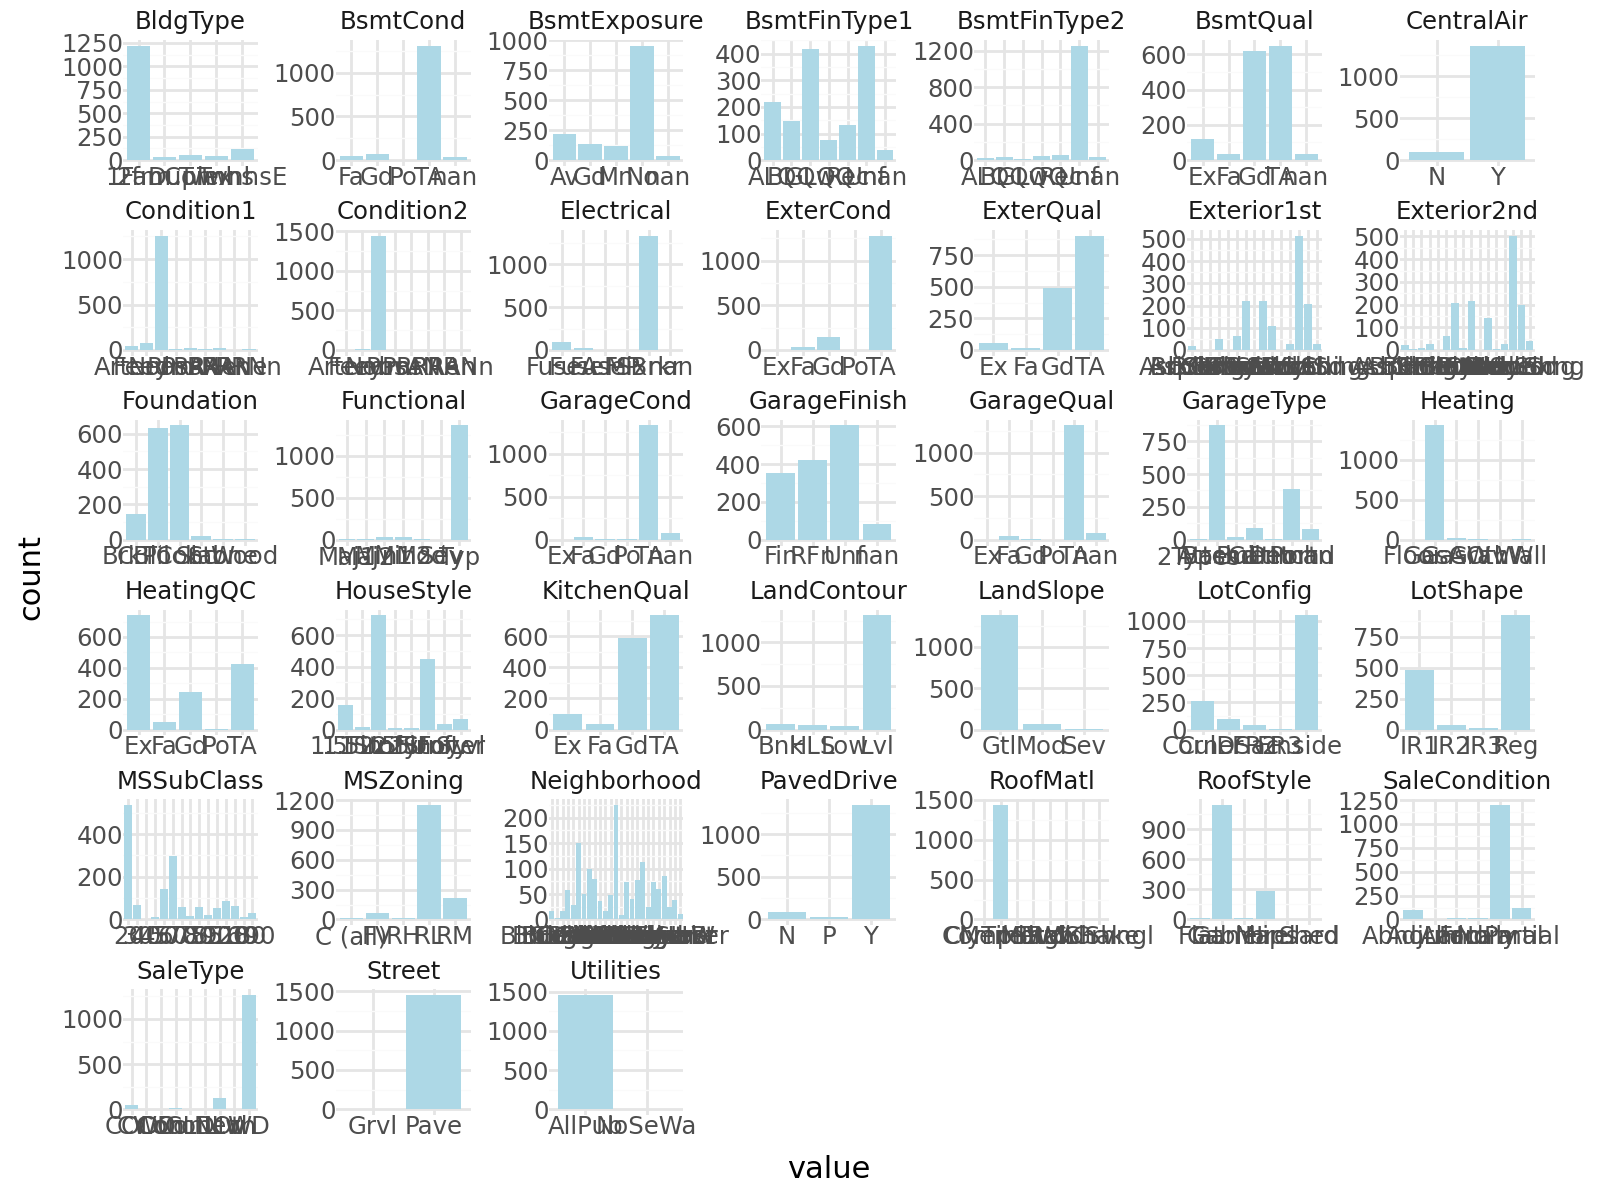

In [86]:
toplot_cat_df = cat_.melt(var_name='feature', value_name='value')

(
    ggplot(toplot_cat_df, aes(x='value')) +
    geom_bar(fill="lightblue") +
    facet_wrap('~feature', scales='free') +
    theme_minimal() +
    theme(figure_size=(8,6))
)


### 2.3.3 Features with mostly only one value. (0.25 points)

- คุณควรเห็นจาก plot สองอันก่อนหน้านี้ว่า features หลายตัวมีค่าเพียงค่าเดียวเป็นส่วนใหญ่ (กราฟที่มียอดสูงใหญ่เพียงยอดเดียว)
- เมื่อ features มีค่าหลักเพียงค่าเดียว พวกมันไม่ได้เพิ่มข้อมูลที่เป็นประโยชน์ให้กับโมเดลการทำนายของเรา (เพราะอะไร?)
- **Task**: คัด features เหล่านี้ออกไป
- **Note**: คุณสามารถเลือกเกณฑ์ของคำว่า "ส่วนใหญ่" (เช่น >=90) ได้ตามต้องการ ในทางปฏิบัติ คุณอาจต้องการตรวจสอบกระบวนการนี้ด้วย cross-validation
- **Hint**:
 - คุณสามารถใช้ `.columns` เพื่อดูชื่อคอลัมน์ทั้งหมด
 - คุณอาจพบว่า `.value_counts()` มีประโยชน์ (ผลลัพธ์ที่ได้จะเรียงตามลำดับจากมากไปน้อย ดังนั้นองค์ประกอบแรกจะเป็นองค์ประกอบที่เกิดขึ้นบ่อยที่สุด) [Documentation](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)
 - ถ้าใช้ threshold = 0.9 ควรจะเหลือแค่ 56 columns

In [87]:
# Exclude all variables with mostly one variable.
threshold = 0.9

# Add your code below to add any categorical variables that have mostly one value
mostly_cat = []
for col in cat_.columns:
  highest_count = cat_[col].value_counts().iloc[0] # test this out to see how it works
  if highest_count / len(cat_) > threshold: # TODO: here
    mostly_cat.append(col)

# Add your code below to add any numerical variables that have mostly one value
mostly_num = []
for col in numeric_.columns:
  highest_count = numeric_[col].value_counts().iloc[0]
  if highest_count / len(numeric_) > threshold: # TODO: here
    mostly_num.append(col)

print(mostly_cat)
print(mostly_num)

house_df_nn_mostly = house_df_nn.drop(mostly_cat + mostly_num, axis=1)
house_df_nn_mostly.shape

['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond', 'PavedDrive']
['LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


(1460, 56)

### 2.3.5 Visualize pairs of variables (0.25 points)

- สำหรับโจทย์ข้อนี้ เราจะดู correlation matrix แทนการใช้ `scatter_matrix` เหมือนก่อนหน้านี้
- การคำนวณตาราง correlation สำหรับตัวแปรเชิงตัวเลขทั้งหมด เราสามารถใช้ `pd.corr()`
  - โค้ดสำหรับการสร้างตาราง correlation มีให้ด้านล่าง **สิ่งสำคัญ**คือเราจะเอามาดูเฉพาะความสัมพันธ์ที่มีค่าเกินกว่าค่าเกณฑ์ (0.8) เพราะจะทำให้ดูง่ายขึ้น

In [88]:
corr_threshold = 0.8 #for easy visualization, will only look at those above threshold
correlation = numeric_.corr().reset_index()
correlation = correlation.melt(id_vars = 'index', var_name = 'feature2', value_name='corr')
correlation.loc[correlation['corr'] < corr_threshold, "corr"] = 0.0
correlation

,index,feature2,corr
0,LotFrontage,LotFrontage,1.0
1,LotArea,LotFrontage,0.0
2,OverallQual,LotFrontage,0.0
3,OverallCond,LotFrontage,0.0
4,YearBuilt,LotFrontage,0.0
...,...,...,...
1291,PoolArea,SalePrice,0.0
1292,MiscVal,SalePrice,0.0
1293,MoSold,SalePrice,0.0
1294,YrSold,SalePrice,0.0


- จากนั้น เราสามารถพล็อต correlation matrix เป็น heatmap โดยใช้ `geom_tile()`
  - แกน x เป็น `index`, แกน y เป็น `feature2`, `fill` เป็น `corr`
  - การเปลี่ยนทิศทางของเครื่องหมายแกน คุณสามารถใช้ `theme(axis_text_x=element_text(rotation=90, hjust=1))`
  - **Note**: เราเห็นเฉพาะอันที่สูงกว่า 0.8!

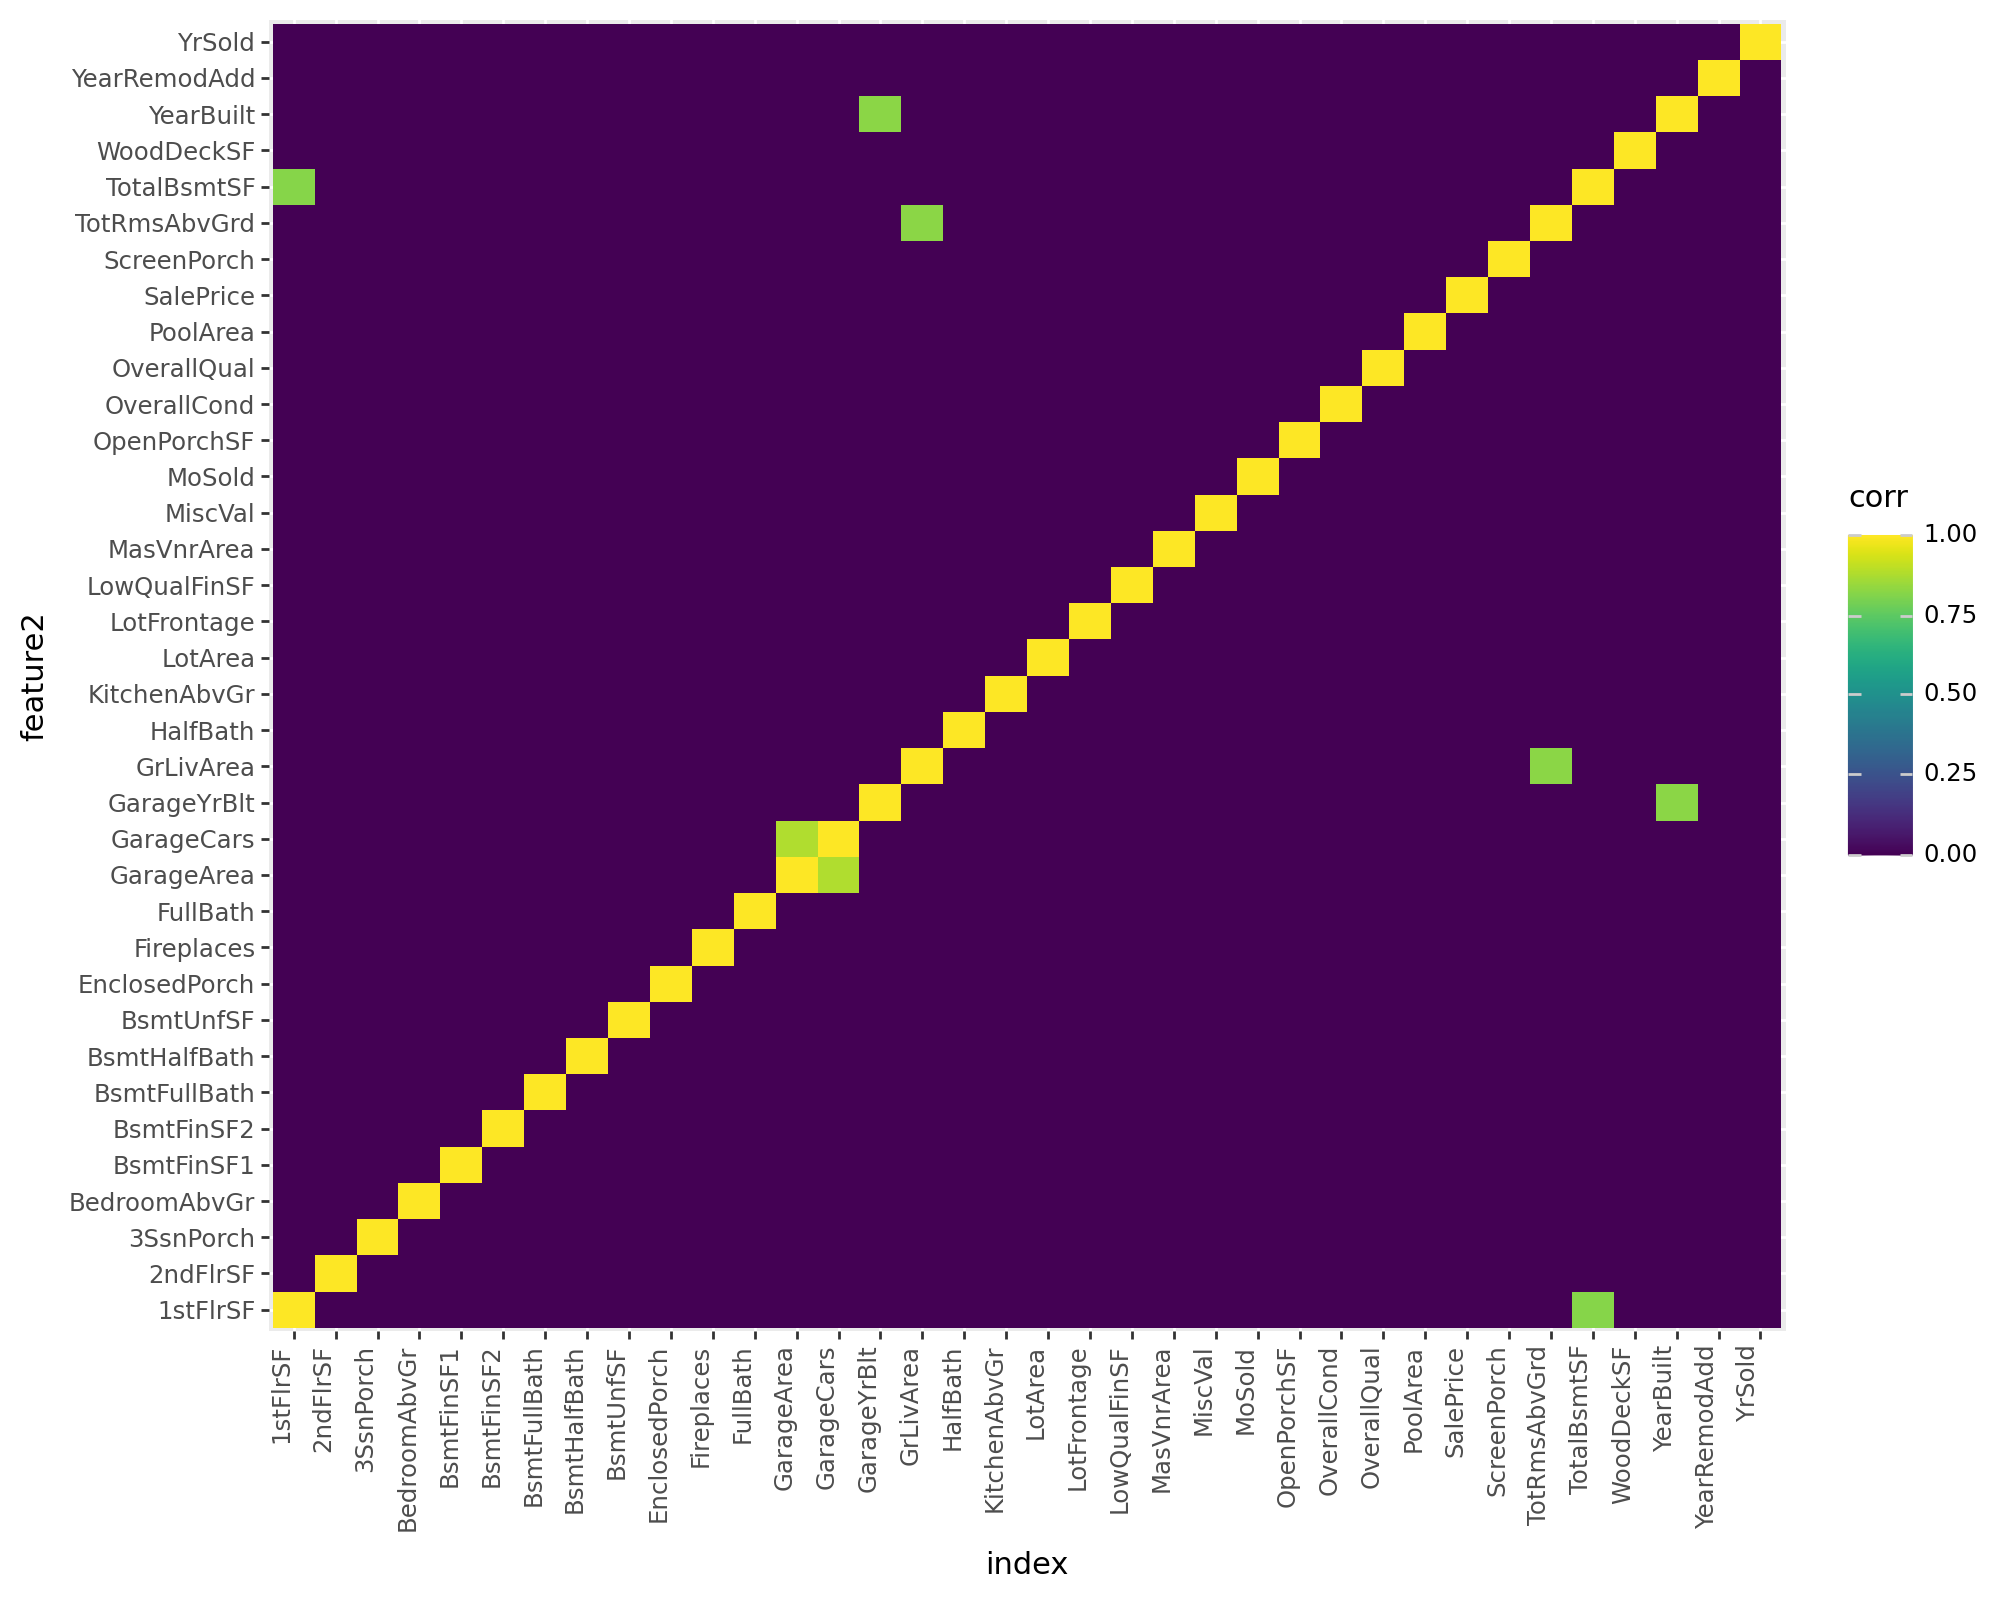

In [89]:
# Plot the correlation matrix using geom_tile below
(
  ggplot(correlation, aes(x='index', y='feature2', fill='corr')) +
  geom_tile()  +
  theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(10,8))
)

### 2.3.6 List the highly correlated pairs (0.25 points)

- แสดง row ของ correlation ที่ `corr` มากกว่า 0.8 และ `corr` ไม่เท่ากับ 1 (เพราะมันคือตัวเอง)

In [31]:
correlation[(correlation['corr'] > 0.8) & (correlation['corr'] != 1)] #TODO: Fill in here

,index,feature2,corr
167,GarageYrBlt,YearBuilt,0.825667
371,1stFlrSF,TotalBsmtSF,0.819530
406,TotalBsmtSF,1stFlrSF,0.819530
525,TotRmsAbvGrd,GrLivArea,0.825489
770,GrLivArea,TotRmsAbvGrd,0.825489
832,YearBuilt,GarageYrBlt,0.825667
889,GarageArea,GarageCars,0.882475
924,GarageCars,GarageArea,0.882475


- ตารางด้านบนควรจะมีอยู่ n คู่ (เช่น 8 คู่) คู่จะซ้ำกันอยู่ครึ่งหนึ่ง ให้ลบ feature ที่มาหลังตามตัวอักษร ของแต่ละคู่ออก เช่น คู่ (`GarageYrBlt`,`YearBuilt`) ให้ลบ `YearBuilt` ออก (เหตุผลหลักๆคือเพื่อให้ตรวจได้ง่าย)
 - ถ้ามี 8 คู่ ตวรจะ ลบแค่ 4 feature
 - ตัวเลขมาก่อนตัวอักษร

In [90]:
to_remove = ['YearBuilt', 'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars'] #TODO: Fill in here

house_df_filter = house_df_nn_mostly.drop(to_remove, axis=1)
house_df_filter.shape

(1460, 52)

- **Note**: เราสามารถดำเนินการต่อและตรวจสอบความสัมพันธ์ระหว่าง features และ target (`SalePrice`) แต่เราจะหยุดที่นี่
- **Importance**: หากคุณพิจารณาที่จะทำสิ่งนี้ในอนาคต คุณต้องมั่นใจว่าคุณจะไม่ดูข้อมูล test!! คุณควรแยก train และ test ก่อนขั้นตอนนี้ (หรือดีกว่าคือตั้งแต่ตอนเริ่มต้น)

### 2.4 Data Processing

มีอีกสองอย่างที่เราต้องทำ:
 - Dealing with outliers
 - Dealing with missing data

### 2.4.1 Dealing with outliers (0.25 points)

- เราจะดู outliers ด้วย boxplot We will use boxplot to visualize outliers.
- เราจะดูเฉพาะ numerical variables

In [91]:
numeric_ = house_df_filter.select_dtypes(exclude=['object']).copy()
numeric_ = numeric_.drop(['MSSubClass'], axis=1)
numeric_.shape

(1460, 25)

- Plot the boxplot for all numerical variables below

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 348 rows containing non-finite values.


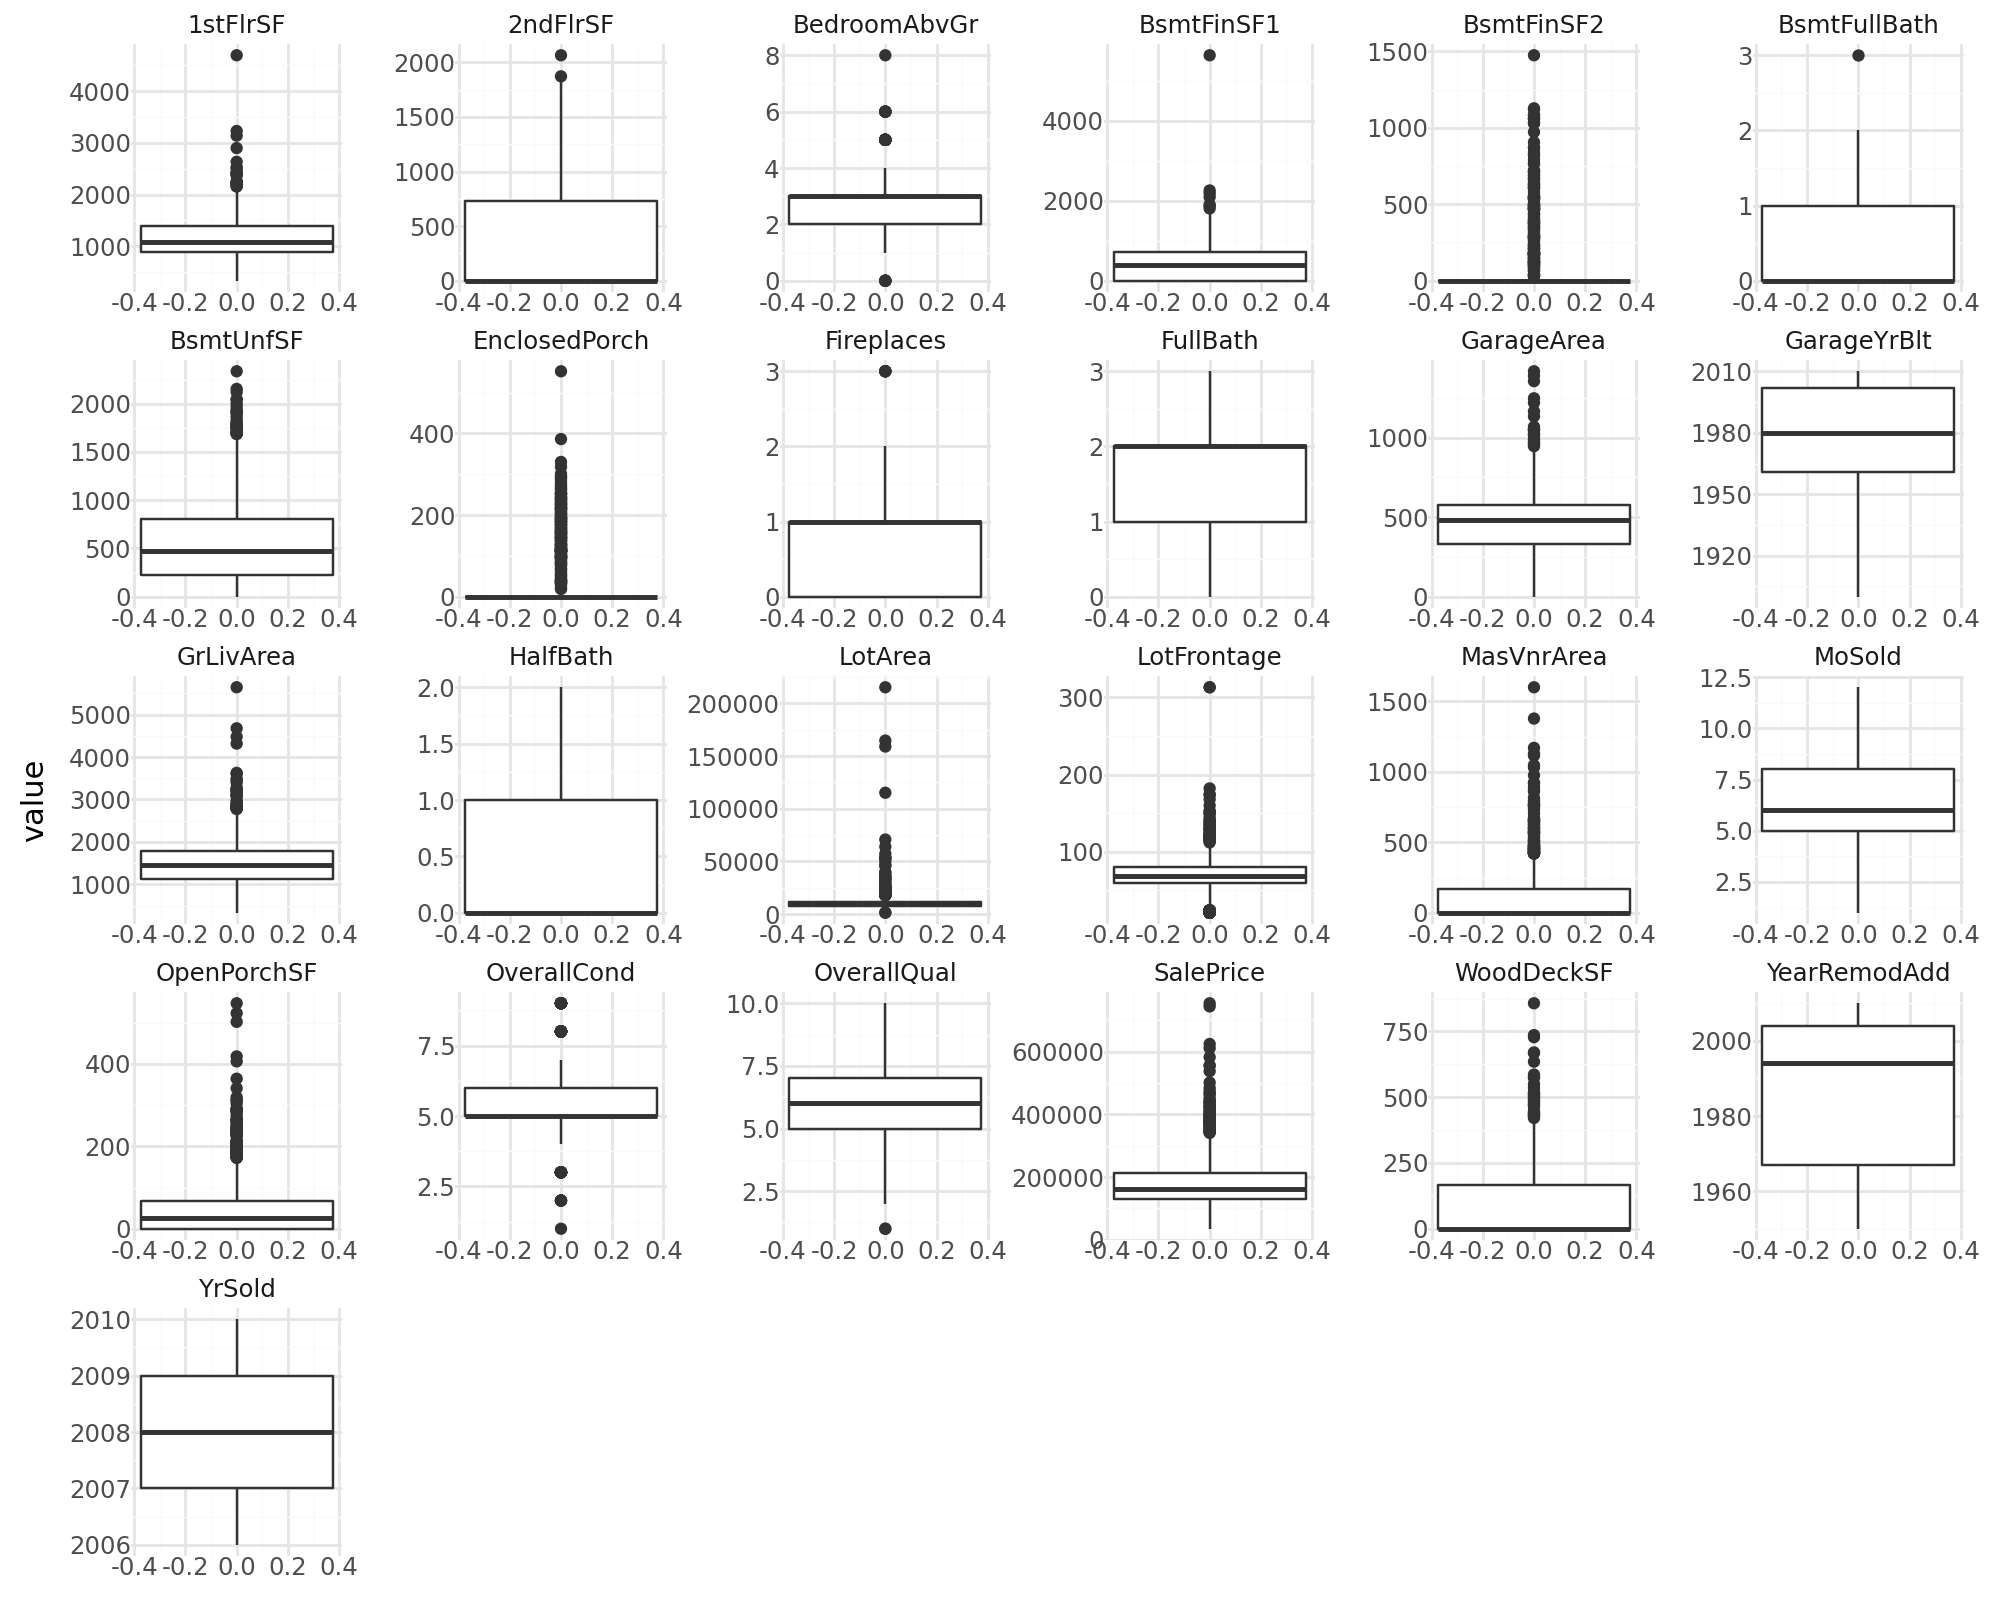

In [92]:
plot_numeric_ = numeric_.melt(var_name='feature', value_name='value')

(ggplot(plot_numeric_, aes(y='value'))
 + facet_wrap('~feature', scales='free', ncol=6)
 + geom_boxplot()
 + theme_minimal()
 + theme(figure_size=(10,8))
)

- จากรูปด้านบนเราจะออกข้อมูลต่อไปนี้ออกที่คิดว่าน่าจะเป็น extreme outliers:
 - 'LotFrontage' > 200
 - 'LotArea' > 100000
 - 'BsmtFinSF1' > 4000
 - 'GrLivArea' > 4000
- **Your task**: เอาแถวข้อนี้ที่ตรงตามเงื่อนไขด้านบนอย่างน้อยหนึ่งอันออก (exclude all data points (row) that satisfy one of the above conditions.)

In [93]:
house_df_filter_o = house_df_filter[
    (house_df_filter['LotFrontage'] <= 200) &
    (house_df_filter['LotArea'] <= 100000) &
    (house_df_filter['BsmtFinSF1'] <= 4000) &
    (house_df_filter['GrLivArea'] <= 4000)
]

house_df_filter_o.shape

(1195, 52)

### 2.4.2 Dealing with missing data (0.25 points)

- เพื่อให้ง่าย (แต่ไม่ใช่วิธีที่ดีที่สุด) งานของคุณคือลบแถวที่มีข้อมูลที่หายไปทั้งหมดโดยใช้ `dropna()` [เอกสารประกอบ](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
- การทำแบบนี้ เราสูญเสียข้อมูลไปจำนวนมาก!!
- อย่างที่เราได้พูดคุยกันก่อนหน้านี้ วิธีที่ดีกว่าคือการ impute ข้อมูลเหล่านั้นด้วยวิธีการบางอย่าง

- To keep thing simple (but not optimal), your task is to simply drop all rows with missing data using `dropna()`. [Documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
- Doing it this way, we lost a lot of data points!!
- As we discussed before, the better way is to impute them somehow.

In [94]:
house_df_filter_om = house_df_filter_o.dropna()

house_df_filter_om.shape

(1089, 52)

## 2.5 Feature Engineering

- เพื่อที่จะทำ feature engineering เราจะต้องใช้ **domain knowledge**
- สำหรับโจทย์นี้ เราจะแปลง features ประเภท categorical ทั้งหมดให้เป็นตัวแปรตัวเลขโดยใช้ **one-hot encoding** ตามที่เราได้อภิปรายในชั้นเรียน
- โชคดีที่ pandas มีฟังก์ชันที่ทำเรื่องนี้โดยเฉพาะ: `pd.get_dummies(df)` [เอกสารอ้างอิง](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)
- ใช้ `get_dummies()` เพื่อแปลงตัวแปร categorical ทั้งหมดด้านล่าง
- จะพบว่ามีจำนวน columns เพิ่มขึ้นจำนวนมาก!!

In [110]:
house_df_final = pd.get_dummies(house_df_filter_om)
house_df_final.shape

(1089, 201)

### 2.6 Choosing the models with Cross-Validation

### 2.6.1 Create train and test dataset (0.25 points)

- Create `X_train`, `X_test`, `y_train`, `y_test` below
- Test_size is 20%. `random_state` is `777`

In [116]:
X = house_df_final.drop(["SalePrice"],axis=1).copy()
y = house_df_final["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)


### 2.6.2 Scaling the data

- ด้วย features ที่หลากหลาย เราจำเป็นต้อง scale ข้อมูลให้อยู่ในช่วงที่เหมาะสมและเดียวกัน
- เราจะ scale เฉพาะ `X_train` เท่านั้น สิ่งสำคัญคือต้องไม่รวม `X_test` ในการคำนวณการแปลง scaling มิฉะนั้นชุดทดสอบของเราจะเกิดการรั่วไหลข้อมูล
- เราจะใช้ `StandardScaler` สำหรับปัญหานี้ (แต่ดู [robust version](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.RobustScaler.html) ด้วย)
  - [Documentation](https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html)
  - อันดับแรกคุณต้องสร้าง object `scaler = StandardScaler()`
  - จากนั้น คุณคำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐาน คุณสามารถทำได้โดยเรียกใช้ `scaler.fit(X)`
  - `scaler` นี้สามารถใช้เพื่อแปลงข้อมูลใดๆ ทั้งชุดฝึกและชุดทดสอบได้โดยเรียกใช้ `scaler.transform(data)`

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

### 2.6.3 Checking 'SalePrice' (0.25 point)

- มาดูให้ละเอียดกว่านี้ที่ `SalePrice` ซึ่งเป็นตัวแปรเป้าหมายของเรา
- สร้างกราฟ histogram ของ `y_train` คุณจะต้องแปลงมันให้เป็น `DataFrame` ก่อน

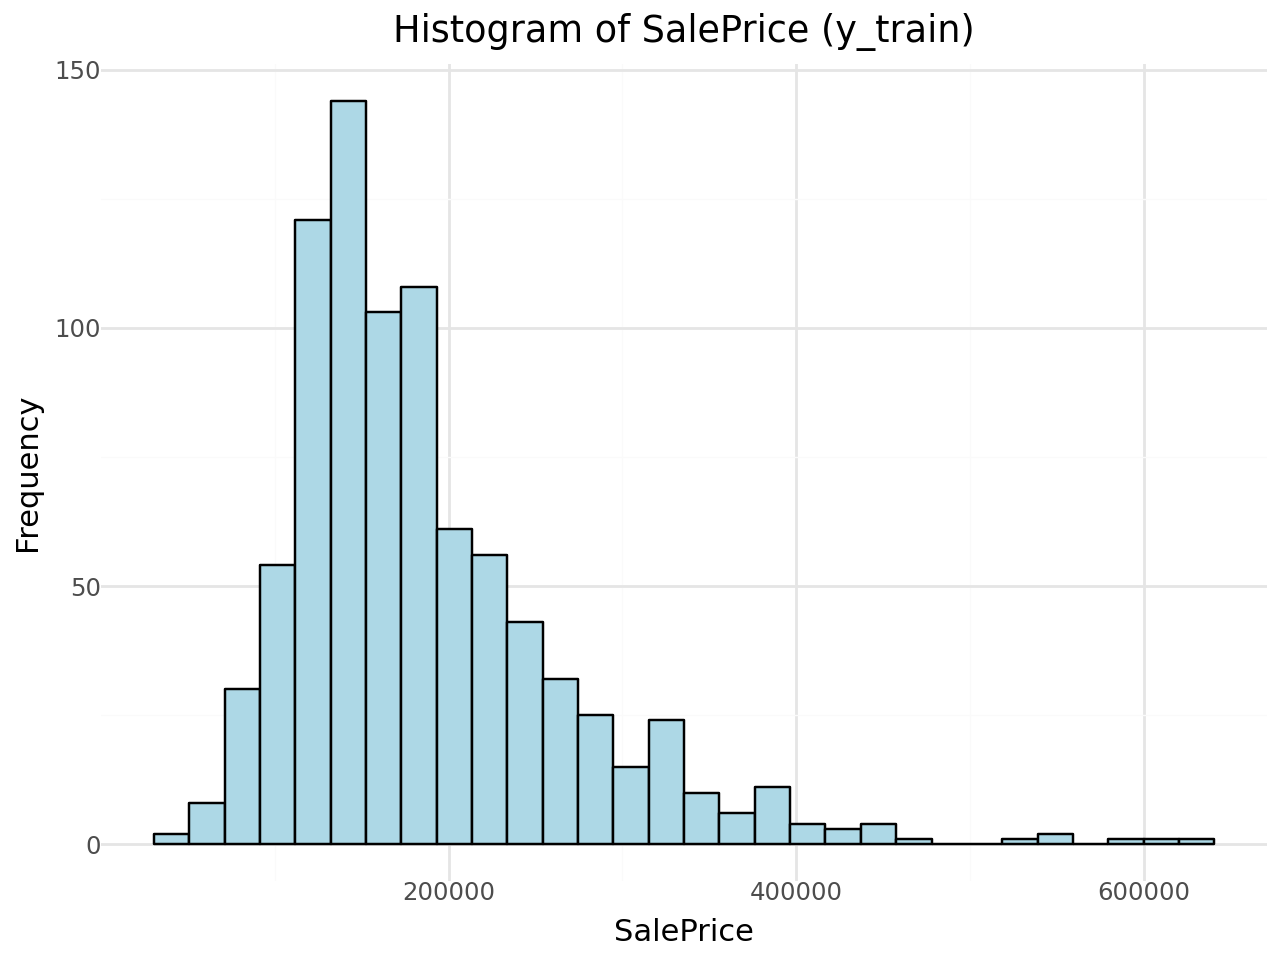

In [118]:
y_train_df = pd.DataFrame(y_train, columns=["SalePrice"])

(
    ggplot(y_train_df, aes(x='SalePrice')) +
    geom_histogram(bins=30, fill='lightblue', color='black') +
    labs(title='Histogram of SalePrice (y_train)', x='SalePrice', y='Frequency') +
    theme_minimal()
)

- ตามที่คุณควรเห็น ค่าและช่วงของ `SalePrice` มีค่าสูงมากและข้อมูลเบ้ไปทางขวา สิ่งนี้อาจก่อให้เกิดปัญหาบางประการกับ mean squared error (ทำไม?)
- ดังนั้น เราจะทำการ log transform `SalePrice`
- เพื่อความง่าย เราจะทำ log transform ทั้ง `y_train` และ `y_test`
- เราสามารถใช้ `np.log(x)`
- **หมายเหตุสำคัญ**: หลังจากนี้เรากำลังทำนายค่า log ของ `SalePrice` เราจำเป็นต้องใช้ exponential หากต้องการกลับไปยังค่า `SalePrice`


In [119]:
y_train = np.log(y_train)
y_test = np.log(y_test)

- Plot `y_train` again below

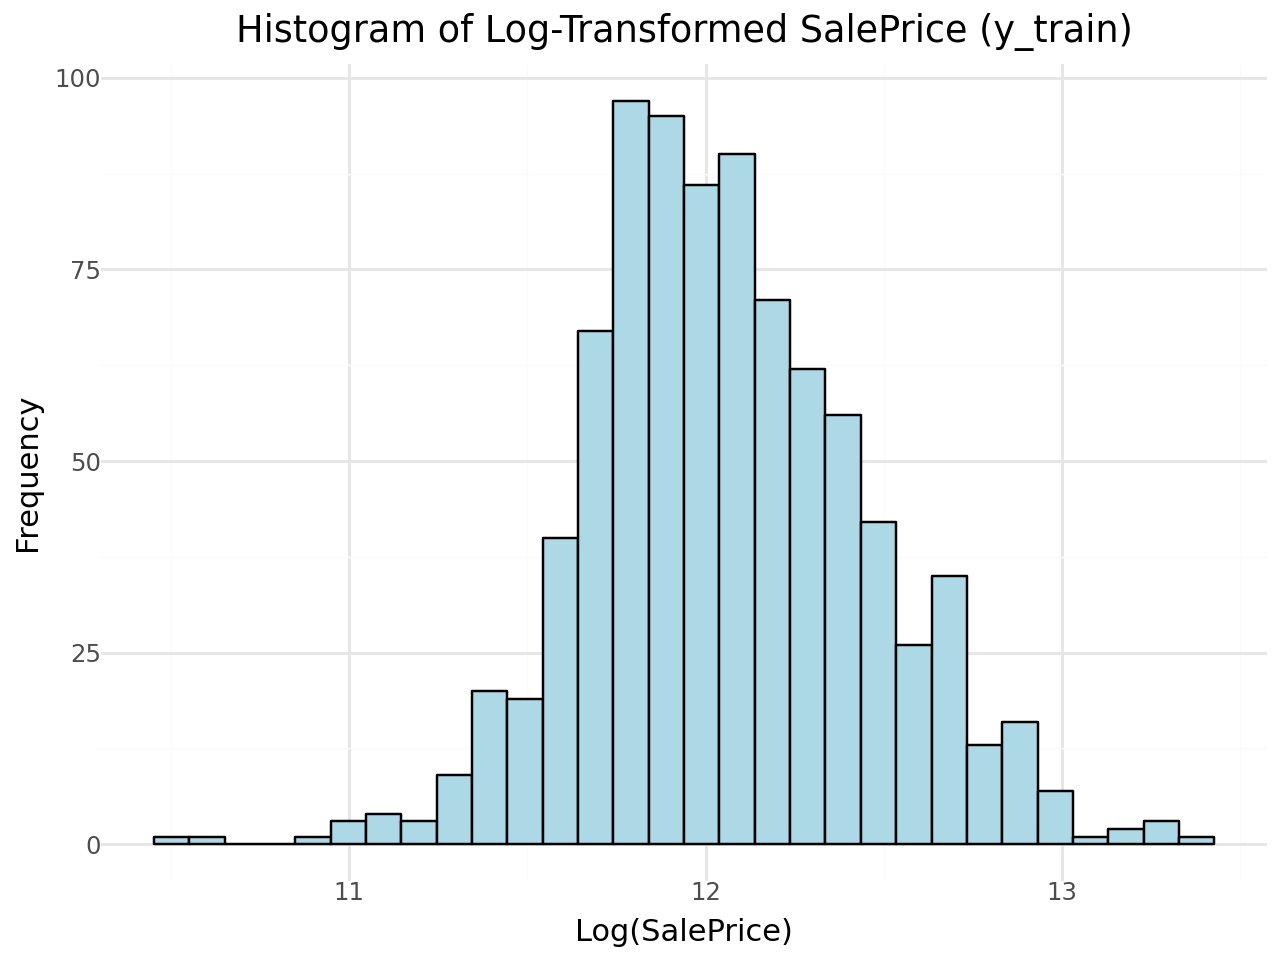

In [120]:
y_train_log_df = pd.DataFrame(y_train, columns=["SalePrice"])

(
    ggplot(y_train_log_df, aes(x='SalePrice')) +
    geom_histogram(bins=30, fill='lightblue', color='black') +
    labs(title='Histogram of Log-Transformed SalePrice (y_train)', x='Log(SalePrice)', y='Frequency') +
    theme_minimal()
)

### 2.6.4 Use Cross-validation to find the best model out of the following five models (0.25 points)
- Use 5-fold CV
- Read the results carefully.

In [121]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression_alpha=1': Ridge(alpha=1.0),
    'Ridge Regression_alpha=.5': Ridge(alpha=.5),
    'Lasso Regression_alpha=1': Lasso(alpha=1.0),
    'Lasso Regression_alpha=.5': Lasso(alpha=.5)
}

cv_results = []

for model_name, model in models.items():
  cv_scores = cross_val_score(model,
                              X_train,
                              y_train,
                              cv=5,
                              scoring='neg_mean_squared_error')
  mean_cv_mse = -cv_scores.mean()
  cv_results.append({
      'Model': model_name,
      'Mean CV MSE': mean_cv_mse,
  })

cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)

                       Model  Mean CV MSE
0          Linear Regression     0.018057
1   Ridge Regression_alpha=1     0.016965
2  Ridge Regression_alpha=.5     0.017378
3   Lasso Regression_alpha=1     0.154320
4  Lasso Regression_alpha=.5     0.154320


## 2.7 Fitting the best model with the whole data (0.25 points)

- Fitting the best model with the whole training data
- คำนวณ MSE ของข้อมูล train และ test
- อย่าลืมแปลง `X_test` ก่อนด้วย `scaler` (จาก 2.6.2)!!

In [122]:
best_model = models['Lasso Regression_alpha=.5']
best_model.fit(X_train, y_train)

X_test = scaler.transform(X_test)

mse_train = mean_squared_error(y_train, best_model.predict(X_train))
mse_test = mean_squared_error(y_test, best_model.predict(X_test))

print(f"MSE train is {mse_train:.2f}. MSE test is {mse_test:.2f}")

MSE train is 0.15. MSE test is 0.14


- Another metric that we could look at is call R-squared.
- We can use `r2_score(y_true, y_predict)` to check it.
- The value is between 0 - 1.0 where 1.0 is perfect predictions.
- You can read more [here](https://scikit-learn.org/1.5/modules/model_evaluation.html#r2-score-the-coefficient-of-determination)

In [123]:
from sklearn.metrics import r2_score

r2_score(y_train, best_model.predict(X_train))

0.0

## What's next?

- If you actually want to submit to kaggle, you will need to predict the test data to submit to kaggle.
- In this class, we won't get to the fancy models and techiques, especially those specialized for ML competitions like kaggle (e.g., tree-based and Ensemble methods) but you can read more [here](https://www.kaggle.com/code/angqx95/data-science-workflow-top-2-with-tuning/notebook#4.2-Ensemble-Algorithms).
- The upside of linear models is that we can 'interpret' them. We will learn more and do more about this in the next homework.